## Library Import

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

## Loading data and handling null values

Luckily, there is no null values in training and testing data (except 1 null in 'comment' column of training but the column won't be used so it's not a problem). I removed some columns that I strongly believe not useful for the analysis, i.e. "_unit_id", "comment", and "_trusted_judgements'. I also change the type of "generalisation_unfair" from float64 (0.0 and 1.0) to boolean value (0 and 1). 

In [2]:
data_dir = Path("../corpus/")
img_dir = Path("../img")

# Load data
train = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Check null values
train.isnull().sum()
test.isnull().sum()
# No null values for training and testing data

# Getting training and testing data, Drop unit_id, _trusted_judgments, comment variable since they are not helpful for analysis
X_train = train.drop(['_unit_id','comment', '_trusted_judgments', 'healthy'], axis=1)
y_train = train['healthy']
X_test = test.drop(['_unit_id','comment', '_trusted_judgments', 'healthy'], axis=1)
y_test = test['healthy']

X_train['generalisation_unfair'] = X_train['generalisation_unfair'].astype('int64')
X_test['generalisation_unfair'] = X_test['generalisation_unfair'].astype('int64')

X_train.head()

Train shape: (35503, 19)
Test shape: (4425, 19)


,antagonise,antagonise:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,1,0.5816,1,0.5816,1,0.5816,0,1.0,0,1.0,0.5816,1,0.5816,0,0.8001
1,0,1.0000,0,1.0000,0,1.0000,0,1.0,0,1.0,0.7981,0,1.0000,0,1.0000
2,0,1.0000,0,0.8063,0,1.0000,0,1.0,0,1.0,0.6081,0,1.0000,0,0.8063
3,0,0.7931,0,0.5959,0,0.5959,0,1.0,0,1.0,0.7917,0,1.0000,0,0.6052
4,0,1.0000,0,1.0000,0,1.0000,0,1.0,0,1.0,1.0000,0,1.0000,0,1.0000


## EDA

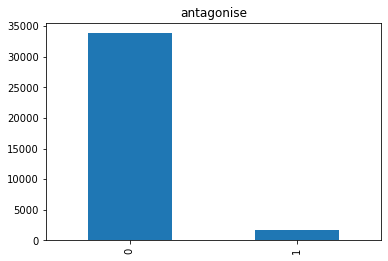

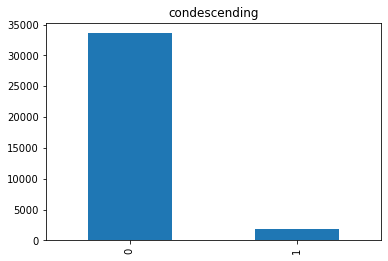

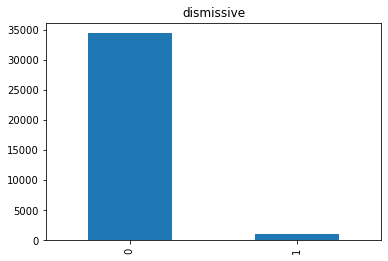

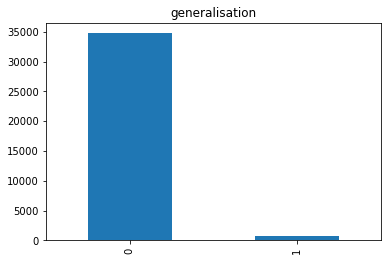

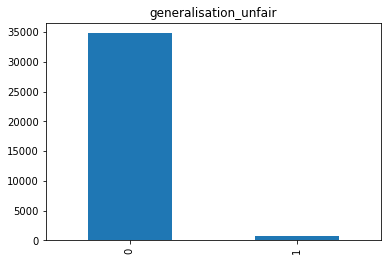

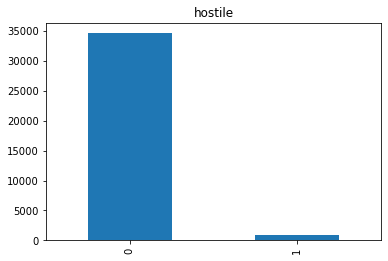

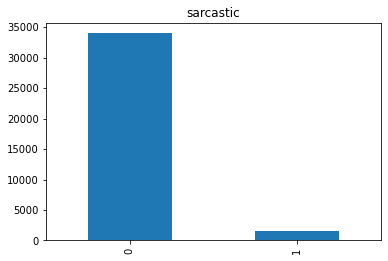

In [3]:
features = ["antagonise", "condescending", "dismissive", "generalisation", "generalisation_unfair", "hostile", "sarcastic"]
for col in features:
    X_train[col].value_counts().plot(kind="bar")
    plt.title(col)
    plt.show()

In [4]:
X_train.select_dtypes(include=[np.float64]).describe()

,antagonise:confidence,condescending:confidence,dismissive:confidence,generalisation:confidence,generalisation_unfair:confidence,healthy:confidence,hostile:confidence,sarcastic:confidence
count,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000,35503.000000
mean,0.935671,0.929935,0.939790,0.960473,0.978715,0.888247,0.950006,0.933269
std,0.126049,0.129269,0.120491,0.100016,0.128954,0.153593,0.110633,0.125645
min,0.500000,0.500000,0.500000,0.500100,0.000000,0.500300,0.500300,0.500800
25%,1.000000,0.844500,1.000000,1.000000,1.000000,0.790600,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'y_train class distribution')

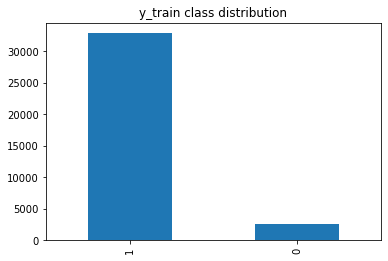

In [5]:
y_train.value_counts().plot(kind='bar')
plt.title("y_train class distribution")

**Comment**: *It is clear that the target variable has a severe imbalance: there are much more healthy comments than unhealthy ones, while what we want the model to detect is unhealthy comment.* 

## Building Model
Since imbalanced class distribution exists, F1-score is a better metric to evaluate the models on. I also look at the recall of 0 (i.e. the percentage of unhealthy detected by the model among the actual unhealthy comments). 

### 1. Logistic Regression 

In [6]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(y_test, lr.predict(X_test)))
print("F1_score: ", f1_score(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.41      0.50       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.94      4425
   macro avg       0.81      0.70      0.74      4425
weighted avg       0.93      0.94      0.94      4425

F1_score:  0.9691513623814668


**Comment:** *Logistic Regression model works pretty well, but the recall is only 0.41, which means that only 41% of unhealthy comments are detected using this model. Will see if for other models, recall is higher.*

### 2. Decision Tree

In [7]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
print(classification_report(y_test, dtc.predict(X_test)))
print("F1 score: ", f1_score(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       320
           1       0.97      0.97      0.97      4105

    accuracy                           0.94      4425
   macro avg       0.78      0.78      0.78      4425
weighted avg       0.94      0.94      0.94      4425

F1 score:  0.9686131386861314


**Comment**: *Though F1 score is slightly lower (yet still very good), Decision Tree has much higher recall and f1-score for class 0. I chose Decision Tree over LR to tune hyper-parameters.*

### 3. Tuning model

In [8]:
tree_grid = {
    "criterion": ["gini"],
    "splitter": ["best"],
    "max_depth": [2, 5, 10, 20, 50, 100, 1000],
    "min_samples_split": [2, 5, 8],
    "min_samples_leaf": [1, 2, 3, 5],
    "max_features": ["auto", "sqrt", "log2"],
    "class_weight": [None, "balanced"],
    "splitter": ["best"]
}

grid_model = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=tree_grid,
    refit = True
)

grid_model.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini'],
                         'max_depth': [2, 5, 10, 20, 50, 100, 1000],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'min_samples_split': [2, 5, 8], 'splitter': ['best']})

In [9]:
print(classification_report(y_test, grid_model.predict(X_test)))
print(f1_score(y_test, grid_model.predict(X_test)))
print(grid_model.best_params_)

              precision    recall  f1-score   support

           0       0.67      0.44      0.53       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.94      4425
   macro avg       0.82      0.71      0.75      4425
weighted avg       0.94      0.94      0.94      4425

0.9701994712809421
{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'best'}


**Comment:** *F1-score is higher after tuning the decision tree model, however the recall for class 0 is much slower (0.44 compared to 0.58).* 

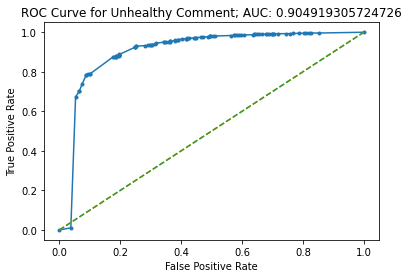

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

auc_score = roc_auc_score(y_test, grid_model.predict_proba(X_test)[:,1])
false_positive, true_positive, _ = roc_curve(
    y_test, grid_model.predict_proba(X_test)[:, 1]
)

plt.plot(false_positive, true_positive, marker=".", label="Decision Tree")
plt.plot([[0, 0], [1.0, 1.0]], linestyle="--", label="line")
plt.title(f"ROC Curve for Unhealthy Comment; AUC: {auc_score}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend
plt.show()

### 4. Applying ensemble method

#### 4.1. Hard Voting classifier

In [11]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

svc = SVC()
rfc = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("rfc", rfc), ("svc", svc)],
    voting="hard",
)
voting_clf.fit(X_train, y_train)

for clf in (lr, rfc, svc, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f1_score(y_test, y_pred))

LogisticRegression 0.9691513623814668
RandomForestClassifier 0.9772041973223978
SVC 0.9707546034420509
VotingClassifier 0.9716277951430633


In [12]:
print(classification_report(y_test, voting_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.46      0.56       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.95      4425
   macro avg       0.83      0.72      0.76      4425
weighted avg       0.94      0.95      0.94      4425



**Comment:** *The f1-score is improved by hard voting, but recall score for class 0 is lower than decision tree model.*

#### 4.2. Soft Voting classifier

In [13]:
soft_svc = SVC(probability=True)

soft_voting_clf = VotingClassifier(
    estimators=[("lr", lr), ("rf", rfc), ("soft svc", soft_svc)],
    voting="soft",
)
soft_voting_clf.fit(X_train, y_train)

for clf in (lr, rfc, svc, soft_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f1_score(y_test, y_pred))

LogisticRegression 0.9691513623814668
RandomForestClassifier 0.9770918736435977
SVC 0.9707546034420509
VotingClassifier 0.9711538461538461


In [14]:
print(classification_report(y_test, soft_voting_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.45      0.55       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.95      4425
   macro avg       0.82      0.72      0.76      4425
weighted avg       0.94      0.95      0.94      4425



#### 4.3. Bagging Classifier

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(classification_report(y_test, bag_clf.predict(X_test)))

0.9701259748050389
              precision    recall  f1-score   support

           0       0.68      0.42      0.52       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.94      4425
   macro avg       0.82      0.70      0.74      4425
weighted avg       0.94      0.94      0.94      4425



**Comment**: *The bagging classifier perform worse than voting classifier, shown by lower f1-score and lower recall score for class 0.*

In [16]:
#### 4.4. AdaBoost Classifier

In [17]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ab_clf.fit(X_train, y_train)
print(classification_report(y_test, ab_clf.predict(X_test)))
print(f1_score(y_test, dtc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.41      0.50       320
           1       0.96      0.98      0.97      4105

    accuracy                           0.94      4425
   macro avg       0.81      0.69      0.74      4425
weighted avg       0.93      0.94      0.94      4425

0.9686131386861314


**Comment**: *The AdaBoost classifier perform even worse than bagging classifier. 

### 5. Apply SMOTE for balancing data

One approach to addressing imbalanced datasets is to oversample the minority class by adding duplicates of minority class examples. However, it might cause overfitting. To mitigate the overfitting problem, a subset of data is taken from the minority class as an example and then new synthetic similar instances are created. These synthetic instances are then added to the original dataset. That is how **Synthetic Minority Oversampling Technique**, or SMOTE works. Since SMOTE is not very effective for high dimensional data, I chose only boolean typed variables.

In [18]:
pip install imbalanced-learn

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter

oversample = SMOTE()
features = ["antagonise", "condescending", "dismissive", "generalisation", "generalisation_unfair", "hostile", "sarcastic"]
smote_X_train, smote_y_train = oversample.fit_resample(X_train[features], y_train)
counter = Counter(smote_y_train)
print(counter)

Counter({0: 32848, 1: 32848})


In [20]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(smote_X_train, smote_y_train)
print(classification_report(y_test, dtc.predict(X_test[features])))

              precision    recall  f1-score   support

           0       0.40      0.65      0.50       320
           1       0.97      0.92      0.95      4105

    accuracy                           0.90      4425
   macro avg       0.69      0.79      0.72      4425
weighted avg       0.93      0.90      0.91      4425



In [21]:
soft_voting_clf.fit(smote_X_train, smote_y_train)
print(classification_report(y_test, soft_voting_clf.predict(X_test[features])))
print(f1_score(y_test, soft_voting_clf.predict(X_test[features])))

              precision    recall  f1-score   support

           0       0.40      0.65      0.49       320
           1       0.97      0.92      0.95      4105

    accuracy                           0.90      4425
   macro avg       0.68      0.79      0.72      4425
weighted avg       0.93      0.90      0.91      4425

0.9465267366316842


In [22]:
voting_clf.fit(smote_X_train, smote_y_train)
print(f1_score(y_test, voting_clf.predict(X_test[features])))
print(classification_report(y_test, voting_clf.predict(X_test[features])))

0.9466583385384135
              precision    recall  f1-score   support

           0       0.40      0.65      0.49       320
           1       0.97      0.92      0.95      4105

    accuracy                           0.90      4425
   macro avg       0.68      0.79      0.72      4425
weighted avg       0.93      0.90      0.91      4425



**Comment**: *Though f1-score of this model is lower than the previous ones (0.94 compared to 0.97), the recall for class 0 is much higher (0.65 compared to 0.56). It means that 65% of unhealthy comments can be detected by this model, pretty okay.This is my final model!*